In [1]:
# Only run this if jupyter cannot find the rivgraph package, but change the path to where you've installed rivgraph.
import sys
sys.path.insert(0,r'X:\RivGraph\code\rivgraph')


## Let's demo RivGraph on the Colville Delta!
This demo shows some of the core functionality and convenient plotting and exporting features provided by RivGraph. The basic steps of RivGraph include: 
1. Instantiate delta (or river) class 
2. Skeletonize the binary mask 
3. Compute the network (links and nodes) 
4. Prune the network (requires user-created shoreline and input nodes for deltas) 
5. Compute morphologic metrics (lengths, widths) 
6. Assign flow directions for each link.
7. Compute some topologic metrics.

Along the way, we'll export some geotiffs and GeoJSONs (or shapefiles if you prefer) for inspection in QGIS. RivGraph requires a **binary mask of the channel network**, preferably georeferenced (i.e., a GeoTiff). For deltas, you will also need to create two shapefiles/GeoJSONs: one of the **shoreline**, and one of the **inlet nodes**. See XXX for guidance on how to create these required geovector files.

### 1. Instantiate delta class

In [2]:
from rivgraph.rivgraph import delta
import matplotlib.pyplot as plt
import os

# Define the path to the georeferenced binary image.
mask_path = r"X:\RivGraph\code\rivgraph\rivgraph\data\Colville\Colville_mask.tif"

# Results will be saved with this name
name = 'Colville' 

# A folder called Colville will be created within this path for storing outputs
results_folder = r"X:\RivGraph\code\rivgraph\rivgraph\data\Results" 

# Boot up the delta class! We set verbose=True to see progress of processing.
colville = delta(name, mask_path, results_folder=results_folder, verbose=True) 

# The mask has been re-binarized and stored as an attribute of colville:
plt.imshow(colville.Imask)

### 2. Skeletonize the binary mask

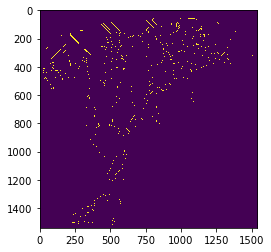

In [3]:
# Simply use the skeletonize() method.
colville.skeletonize()

# After running, colville has a new attribute: Iskel. Let's take a look.
plt.imshow(colville.Iskel)

In [4]:
# The skeleton is hard to see; perhaps we'd like to look at it closer?
# One option is to save it as a geotiff and pull it up in a GIS (like QGIS).
# We use the write_geotiff() method with the "skeleton" option.
colville.to_geotiff('skeleton')

Geotiff written to X:\RivGraph\code\rivgraph\rivgraph\data\Results\Colville\Colville_skel.tif.


The georeferenced Colville skeleton has been written to disk, so we can pull it up in QGIS along with the georeferenced mask:

![colville_qgis_mask_skel_large.PNG](images/colville_qgis_mask_skel_large.png)

Or a bit zoomed-in: 

![colville_qgis_mask_skel_zoom.PNG](images/colville_qgis_mask_skel_zoom.png)


### 3. Compute the network (links and nodes)

In [5]:
# Simply use the compute_network() method.
colville.compute_network()

Resolving links and nodes...done.


In [6]:
# Now we can see that the "links" and "nodes" dictionaries have been added as colville attributes:
links = colville.links
nodes = colville.nodes
print('links: {}'.format(links.keys()))
print('nodes: {}'.format(nodes.keys()))

links: dict_keys(['idx', 'conn', 'id', 'n_networks'])
nodes: dict_keys(['idx', 'conn', 'id'])


The *links* dictionary currently contains four keys: 
-  <i>idx</i>: a list of all the pixel indices that make up the link (indices created with input mask shape and np.ravel_multi_index)
- <i>conn</i> : a two-element list containing the node *id*s of the link's endpoints
- <i>id</i>: each link has a unique *id*; the ordering is irrelevant
- <i>n_networks</i>: the number of disconnected networks (==1 if the input mask contains a single connected blob)
    
The *nodes* dictionary currently contains three keys:
- <i>idx</i>: the index of the node's position within the original image (i.e. np.ravel_multi_index())
- <i>conn</i>: an N-element list containing the N link *id*s of the links connected to this node.
- <i>id</i>: each node has a unique *id*; the ordering is irrelevant
    
We can visualze the network in a couple of ways. First, we can plot with matplotlib:

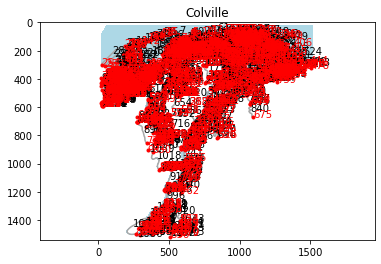

In [7]:
colville.plot('network')

Nodes and links are labeled with their ids. Kind of hard to see, so we can zoom in OR we can export the network to geovectors and pull 'em into QGIS:

In [8]:
colville.to_geovectors('network', ftype='json') # ftype can be either 'shp' or 'json'

# Let's see where the network geovector files were written:
print(colville.paths['links'])
print(colville.paths['nodes'])

X:\RivGraph\code\rivgraph\rivgraph\data\Results\Colville\Colville_links.json
X:\RivGraph\code\rivgraph\rivgraph\data\Results\Colville\Colville_nodes.json


And dragging these into QGIS:
![colville_network_unpruned.PNG](images/colville_network_unpruned.png)
You can query different links and nodes using the Identify tool. Note that their properties ('conn' and 'id') are appended.

### 4. Pruning the network

You notice in the above image that there are many superfluous links along the shoreline. This is a result of skeletonizing such a massive, connected waterbody (i.e. the ocean in this case). Additionally, the network contains a number of "dangling" links, or those that are connected only at one end. We want to keep the inlet and outlet dangling links, but not the others! RivGraph will automatically prune the network, but it requires (for deltas) two additional pieces of information: the location of the inlet nodes, and a delineation of the shoreline.
We can create both of these in QGIS:

![colville_shoreline_inlet_outlet.png](images/colville_shoreline_inlet_outlet.png)

<b>Shoreline</b>: Create a polyline vector layer. The shoreline should be drawn to intersect all the outlet links. It should separate all the unwanted ocean links from the actual links of the delta channel network. If you get errors, you may need to adjust your shoreline a little--try to ensure it does not intersect any nodes!

<b>Inlet nodes</b>: Create a point vector layer. Simply place points at nodes that represent the inlets to the network. The placement does not need to be exact; RivGraph will find the closest node to the one(s) you create. These will be marked as inlet nodes and won't be removed during pruning.

<b>Saving</b>: For convencience, these files should be saved in the Results folder that you initialized the class. Save as <i>results_folder/Colville_shoreline.shp</i> and <i>results_folder/Colville_inlet_nodes.shp</i>. However, this is not mandatory as you can also point to the files during pruning. 


Now that we have identified the shoreline and inlet/outlet nodes, let's prune the network!

In [9]:
colville.prune_network()
# Note that we can also specify the location of the shoreline and inlet nodes:
# colville.prune_network(path_shoreline=/path/to/shoreline/shapefile, path_inletnodes=/path/to/inletnodes/shapefile)

# Now that we've pruned, we should re-export the network:
colville.to_geovectors()
# Note that this time we didn't specify the arguments; by default 'network' will be exported as type 'json'.

Let's see how the pruned version compares to the unpruned:

![colville_shoreline_inlet_outlet_pruned.png](images/colville_shoreline_inlet_outlet_pruned.png)

Wow, we really clipped off a lot of links! We also added some new nodes at the shoreline--notice how each link that intersects the shoreline was truncated, and outlet nodes were placed there (RivGraph remembers which nodes are outlet nodes). You may be concerned that some of the dangling links or subnetworks were pruned--this is by design, and if you want to retain any dangling links, you need to mark their upstream-most nodes as inlet nodes in your shapefile.

Compare with the figure above this one; the set of nodes was also reduced. As links were removed from the network, some nodes were no longer needed as they only connected two links.

### 5. Compute morphologic metrics (lengths, widths)
Now that the network is resolved and pruned, we can compute some link metrics.

Computing distance transform...done.


Text(0.5, 1.0, 'Histogram of link lengths')

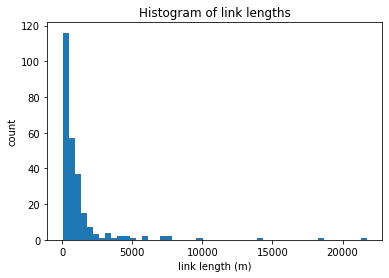

In [10]:
# Compute link widths and lengths
colville.compute_link_width_and_length()

# Lets look at histograms of link widths and lengths:
trash = plt.hist(colville.links['len_adj'], bins=50)
plt.ylabel('count')
plt.xlabel('link length (m)')
plt.title('Histogram of link lengths')

In the above figure, we see that almost all the links are 1 km or shorter, with three being much longer. This histogram will be different for each delta, and can depend on the resolution of your input binary mask. 

<b>Note</b>: the lengths are reported in <b>meters</b> because that is the unit of the original geotiff CRS. You can check this unit with ```print(colville.unit)```. It is highly unadvisable to use degrees (EPSG:4326 and others) to compute distances.

<b>Note</b>: we used the 'len_adj' field rather than the 'len' field. The difference is addressed in a separate Jupyter notebook called XXX. 



We can do the same for the widths:

Text(0.5, 1.0, 'Histogram of link widths')

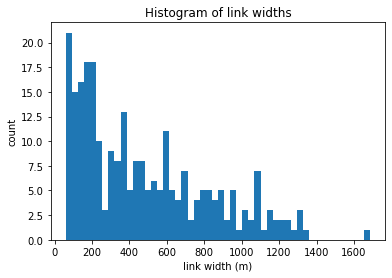

In [11]:
trash = plt.hist(colville.links['wid_adj'], bins=50)
plt.ylabel('count')
plt.xlabel('link width (m)')
plt.title('Histogram of link widths')    

### 6. Assign flow directions for each link.
Now we wish to determine the long-term, steady-state flow direction in each link. The algorithms used here are described in [this paper](https://www.earth-surf-dynam.net/8/87/2020/esurf-8-87-2020.html).

In [12]:
colville.assign_flow_directions()

No cycles were found in network.


If RivGraph has any problems assigning link directions, it will let us know. Here, we see no error messages, and a message indicating no cycles were found in the graph. Great! Let's look at some plots.


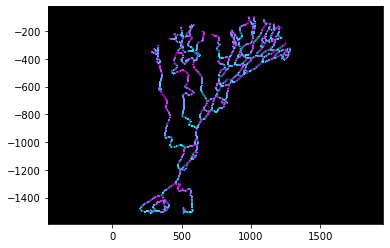

In [13]:
# Plot the links with the directionality marked
colville.plot('directions')

Links are colored such that upstream is cyan and downstream is purple. Similar to the skeleton, we can export the link directions as a geotiff for inspection in a GIS:

In [14]:
colville.to_geotiff('directions')

Geotiff written to X:\RivGraph\code\rivgraph\rivgraph\data\Results\Colville\Colville_link_directions.tif.


Pulling this into QGIS and applying a similar color ramp, we see

![colville_link_directions.PNG](images/colville_link_directions.png)

The pixel values along each link have been rescaled from 0 (upstream) to 1 (downstream).



In [21]:
# Now that flow directions have been computed, we can also compute junction angles at each node. 
# As of 3/4/2020, this method only computes junction angles at nodes that have exactly three connecting links.
colville.compute_junction_angles(weight=None) # See XXX for a description and meaning of the weight options.

# If we check the the nodes dictionary, we should see that three new fields exist: 'int_ang', 'jtype', and 'width_ratio'.
# 'int_ang' is the junction angle. 'jtype' is either 'b' (bifurcation), 'c' (confluence), or -1 for nodes for which the
# junction angles cannot be computed. 'width_ratio' refers to the ratio between the larger and smaller links.
print(colville.nodes.keys())

dict_keys(['idx', 'conn', 'id', 'inlets', 'outlets', 'arts', 'int_ang', 'jtype', 'width_ratio'])


### 7. Compute topologic metrics

RivGraph will compute a number of topologic metrics for your delta channel network. These metrics are explained and demonstrated in Tejedor et. al [2015a](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014WR016577) and [2015b](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2014WR016577). Note that some pre-processing is done to the topology to compute these metrics; it is highly recommended that you understand these preprocessing steps and/or compute the metrics yourself.

In [28]:
colville.compute_topologic_metrics() # You may get an overflow warning

# The metrics are stored in an attribute dictionary:
print(colville.topo_metrics.keys())

dict_keys(['nonlin_entropy_rate', 'nER_prob_exceedence', 'nER_randomized', 'top_mutual_info', 'top_conditional_entropy', 'top_link_sharing_idx', 'n_alt_paths', 'resistance_distance', 'top_pairwise_dependence', 'flux_sharing_idx', 'leakage_idx', 'dyn_pairwise_dependence', 'dyn_mutual_info', 'dyn_conditional_entropy'])


In [37]:
# Query different metrics by accessing the dictionary by key.
print(colville.topo_metrics['nonlin_entropy_rate'])

0.7627830061288702


In [40]:
# Most metrics are computed for each outlet node
print(colville.topo_metrics['top_mutual_info']) # The first column are node IDs, the second are the topological mutual information values.

[[154.           4.47808224]
 [155.           4.37110328]
 [156.           4.41255783]
 [157.           4.90108782]
 [158.           4.33559163]
 [159.           4.85528415]
 [160.           4.2565915 ]
 [161.           4.32116316]
 [162.           4.31980623]
 [163.           3.72821706]
 [164.           4.32029182]
 [165.           3.70520925]
 [166.           4.40958788]
 [167.           4.32029182]
 [168.           4.38182681]
 [169.           3.80626417]
 [170.           4.38921103]
 [171.           4.39717845]
 [172.           4.41455513]
 [173.           4.44750925]
 [174.           4.4528386 ]
 [175.           4.3148638 ]
 [176.           4.32304436]]


If you wish to compute your own metrics or perform topological analyses, you'll probably need an adjacency matrix. RivGraph will provide this with the following method:

In [33]:
# Unweighted, unnormalized adjacency matrix
adj = colville.adjacency_matrix() 
print(adj)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
# You may also want an adjacency matrix weighted by link width.
adj_w = colville.adjacency_matrix(weight='wid_adj') # Can also weight by 'len_adj' or provide a vector of your own weights.
print(adj_w)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [95.23358675  0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [36]:
# And you may want this adjacency matrix normalized.
adj_w_n = colville.adjacency_matrix(weight='wid_adj', normalized=True)
print(adj_w_n) # Each row sums to 1

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.40569465 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
